## Generate Dataset

We want to build up a neural network that learns a certain distribution. 
In the present notebook, we use the "moon" distribution.

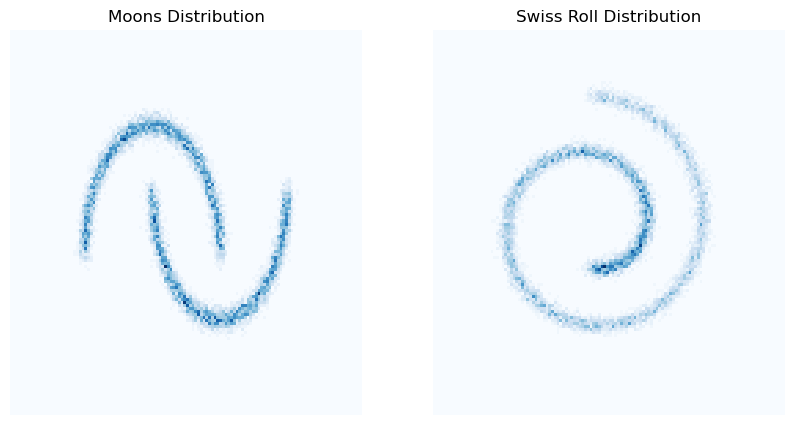

In [2]:
from sklearn.datasets import make_moons,make_swiss_roll
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
from typing import *

def get_data(dataset: str, n_points: int) -> np.ndarray:
  if dataset == "moons":
    data, _ = make_moons(n_points, noise=0.05)
  elif dataset == "swiss":
    data, _ = make_swiss_roll(n_points, noise=0.5)
    data = data[:, [0, 2]] / 10.0
  return StandardScaler().fit_transform(data)

def plot_dist(data:Union[np.ndarray, torch.Tensor], title:Optional[str]=None, ax=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=(5,5))
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    ax.hist2d(data[:, 0], data[:, 1], bins=128,range=[[-3, 3], [-3, 3]],cmap="Blues")
    if title is not None:
        ax.set_title(title)
    ax.axis("off")
    if ax is None:
        plt.show()

fig,axs=plt.subplots(1,2,figsize=(10,5))
plot_dist(get_data("moons", 10000), "Moons Distribution",ax=axs[0])
plot_dist(get_data("swiss", 10000), "Swiss Roll Distribution",ax=axs[1])

Set up test metric

In [3]:
def wasserstein_distance(x, y, p=1):
    """
    Computes the Wasserstein distance between two distributions x and y.
    
    Args:
        x (torch.Tensor): A tensor of shape (n_samples, n_features).
        y (torch.Tensor): A tensor of shape (m_samples, n_features).
        p (int): The order of the Wasserstein distance. Defaults to 1 (W1 distance).
    
    Returns:
        float: The Wasserstein distance between x and y.
    """
    n = x.shape[0]
    m = y.shape[0]
    x_broadcast = x.unsqueeze(1).repeat(1, m, 1)  # shape (n, m, n_features)
    y_broadcast = y.unsqueeze(0).repeat(n, 1, 1)  # shape (n, m, n_features)
    pairwise_distances = torch.norm(x_broadcast - y_broadcast, dim=2, p=p)  # shape (n, m)
    min_row, _ = torch.min(pairwise_distances, dim=1)
    min_col, _ = torch.min(pairwise_distances, dim=0)
    distance = torch.mean(min_row) + torch.mean(min_col)
    return distance.item()

Set up networks and training function

In [4]:
import torch,math
import torch.nn as nn
from tqdm import tqdm

class Net(nn.Module):
    def __init__(self, in_dim: int=2, out_dim: int=2, h_dims: List[int]=[512]*4,dim_time=32) -> None:
        super().__init__()
        half_dim = dim_time // 2
        embeddings = math.log(10000) / (half_dim - 1)
        self.t_embeddings_base = torch.exp(torch.arange(half_dim) * -embeddings)
        
        ins = [in_dim + half_dim*2] + h_dims
        outs = h_dims + [out_dim]
        self.layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)]
            )
        self.out = nn.Sequential(nn.Linear(out_dim, out_dim))
        
    def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
        embeddings = t[:, None] * self.t_embeddings_base.to(t.device)[None, :]
        return torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, self.time_encoder(t)), dim=-1)
        for layer in self.layers:
            x = layer(x)
        return self.out(x)

def train(
    loss_func: Callable[[nn.Module, torch.Tensor], torch.Tensor],
    eval_func: Optional[Callable[[nn.Module, torch.Tensor], torch.Tensor]]=None,
    dataset: str="moons",
    n_data: int=10240,
    batch_size: int=1024,
    n_epochs: int=500,
    lr: float=1e-4,
    device: torch.device=torch.device("cuda"),
):
    train_dataset=torch.from_numpy(get_data(dataset,n_data)).to(device,torch.float32)
    data_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    network=Net().to(device)
    optimizer=torch.optim.AdamW(network.parameters(),lr=lr)
    train_losses=[]
    if eval_func is not None:
        eva_dataset=torch.from_numpy(get_data(dataset,1000)).to(device,torch.float32)
        eval_losses=[]
    p_bar=tqdm(range(n_epochs))
    for epoch in p_bar:
        loss_i=[]
        for x1 in data_loader:
            x1=x1.to(device)
            loss=loss_func(network,x1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_i.append(loss.item())
        train_losses.append(np.mean(loss_i))
        p_bar.set_description(f"Loss: {train_losses[-1]:.4e}")
        if eval_func is not None and epoch%5==0:
            prediction=eval_func(network,torch.randn((1000,2),device=device))
            wd=wasserstein_distance(eva_dataset,prediction)
            eval_losses.append((epoch,wd))
    if eval_func is not None:
        return network, train_losses, eval_losses
    return network, train_losses

## Diffusion

In [4]:
from distrans.diffusion import Cos2ScheduleDiffuser

dif_evals=[]
steps=[10,50,100,200,500,1000]

for n_step in steps:
  diffuser=Cos2ScheduleDiffuser(steps=n_step,device=torch.device("cuda"))
  sample_func=lambda network,x:diffuser.DDPM_sample(network,x,show_progress=False)
  network, train_losses, eval_losses =train(diffuser.diffusion_loss,sample_func,n_epochs=1000)
  dif_evals.append(eval_losses)


Loss: 4.1049e-01: 100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


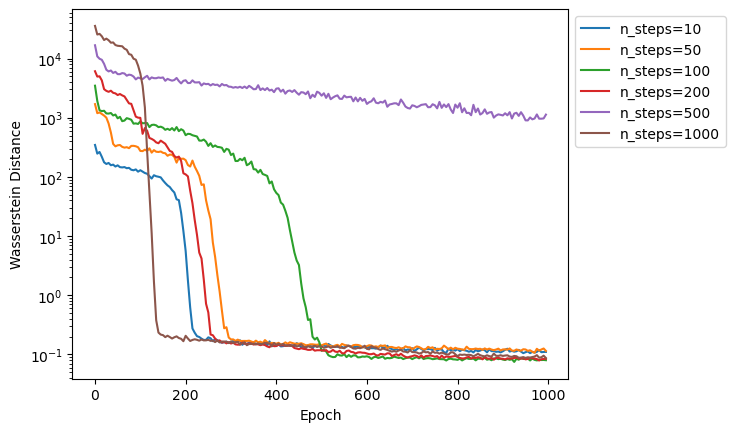

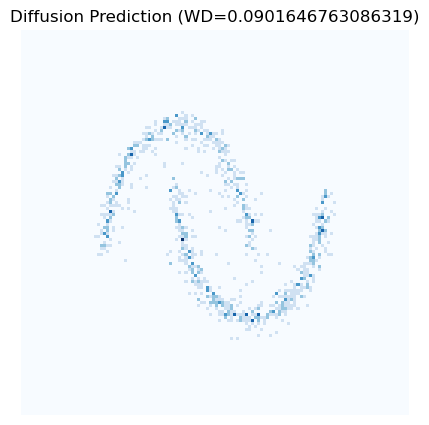

In [5]:
for eval_losses,n_step in zip(dif_evals,steps):
  plt.plot([e_i[0] for e_i in eval_losses],[e_i[1] for e_i in eval_losses],label=f"n_steps={n_step}")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Wasserstein Distance")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

device=network.parameters().__next__().device
prediction=sample_func(network,torch.randn((1000,2),device=device))
wd=wasserstein_distance(torch.from_numpy(get_data("moons",1000)).to(device,torch.float32),prediction)
plot_dist(prediction,f"Diffusion Prediction (WD={wd})")

## Flow Matching

In [5]:
from distrans.flowmatching import OTCondFlowMatcher

sample_func=lambda net, x: fmatcher.fixed_step_sample(net, x, 20)
fmatcher=OTCondFlowMatcher()
network, losses, eval_flow =train(fmatcher.cfm_loss,
                             sample_func,
                             n_epochs=1000)

Loss: 1.3867e+00: 100%|██████████| 1000/1000 [00:51<00:00, 19.25it/s]


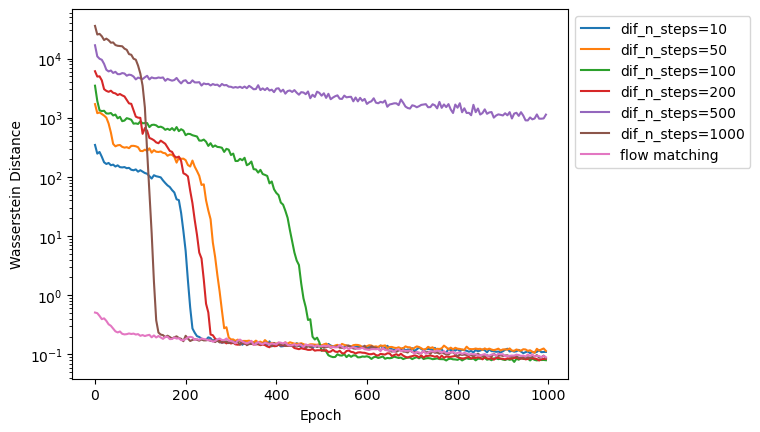

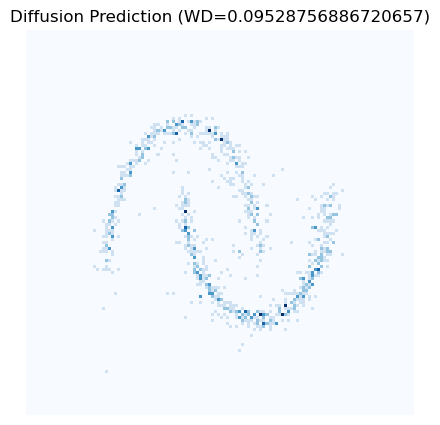

In [11]:
for eval_losses,n_step in zip(dif_evals,steps):
  plt.plot([e_i[0] for e_i in eval_losses],[e_i[1] for e_i in eval_losses],label=f"dif_n_steps={n_step}")
plt.plot([e_i[0] for e_i in eval_flow],[e_i[1] for e_i in eval_flow],label=f"flow matching")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Wasserstein Distance")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

device=network.parameters().__next__().device
prediction=sample_func(network,torch.randn((1000,2),device=device))
wd=wasserstein_distance(torch.from_numpy(get_data("moons",1000)).to(device,torch.float32),prediction)
plot_dist(prediction,f"Diffusion Prediction (WD={wd})")

In [7]:
device=network.parameters().__next__().device

Flow Matching sampling with different number of steps

In [15]:
data=torch.from_numpy(get_data("moons",1000)).to(device,torch.float32)
x_0=torch.randn_like(data)

steps=[10,20,50,100,200,300,400,500,600,700,1000]
wds=[]
for n_step in tqdm(steps):
    prediction=fmatcher.fixed_step_sample(network,x_0,n_step)
    wds.append(wasserstein_distance(data,prediction))

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Adaptive sampling

In [18]:
adaptive_prediction=wasserstein_distance(data,fmatcher.adaptive_sample(network=network,x_0=x_0))

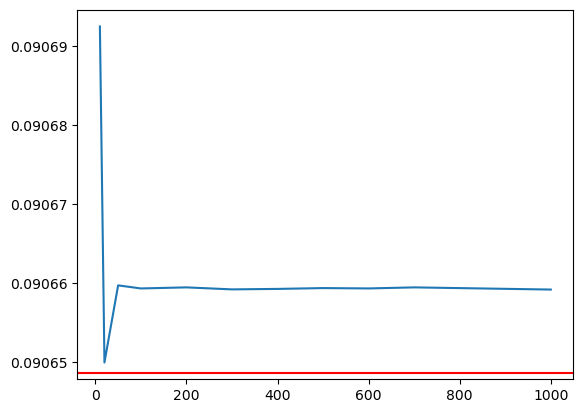

In [ ]:
plt.plot(steps,wds,label="Fixed Step")
plt.axhline(adaptive_prediction,color="red",label="Adaptive Step")
plt.xlabel("Steps")
plt.ylabel("Wasserstein Distance")
plt.legend()
plt.show()